<a href="https://colab.research.google.com/github/clferreira1985/PUC_RJ-Pos_Ciencia_de_Dados_e_Analytics/blob/main/MVP_Sprint_2_B_Machine_Learning_e_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de imagens multiclasse - 10 Tipos de animais

**Contexto:** Temos um conjunto de imagens de 10 tipos de animais diferentes. O objetivo deste nottebook é criar um modelo de visão computacional que consiga classificar uma imagem dentre essas catergorias.

**Estrutura:** O notebook está dividido assim:

1. Importação das bibliotecas
2. Acesso e tratamento dos dados que serão a entrada do modelo de deep learning
3. Separação do dados de Treino e teste
4. Configuração do modelo de deep learning usando uma rede neural convolucional (CNN) simples com Keras
5. Treinamento do modelo de deep learning
6. Execução do modelo de deep learning treinado
7. Avaliação do modelo de deep learning
8. Exportação do modelo de deep learning
9. Teste do modelo exportado

**Créditos:** O notebook foi desenvolvido e documentado por:

- Cleiton Silva

**Dataset:** O dataset foi baixado do Kaggle, uma plataforma online voltada para cientistas de dados, entusiastas de aprendizado de máquina e profissionais afins. O uso é estritamente didático. Para mais informações sobre o dataset, veja o link a seguir: [animal10](https://www.kaggle.com/datasets/viratkothari/animal10).


## 1. Imports das bibliotecas necessárias para executar o notebook

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import random
import math
import shutil
import psutil
from PIL import Image
from datetime import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers,models,Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, shuffle
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
import itertools
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



## 2. Acessando e tratando os dados que serão a entrada do modelo de deep learning

As imagens estão organizadas em pastas dentro do meu google drive, então carrego as imagens de diferentes categorias em um diretório específico e crio um dataframe chamado df com as informações sobre as imagens. A coluna imagens mostrará o caminho completo para cada imagem.

In [ ]:
# Vamos pegar todos os arquivos dentro da pasta que armazenei todas as imagens e transformar em um dataset
%%time
folder_path = r"/content/drive/MyDrive/Puc - Pós em Ciência de Dados e Analytics /Redes Neurais/Dataset/Animais"

data = {"images": [] , "heights": [], "widths": [], "animal": []  }

category = os.listdir(folder_path)
for folder in category:
    folderpath = os.path.join(folder_path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["images"].append(fpath)
        data["animal"].append(folder)
        img_shape = Image.open(fpath)
        data["heights"].append(img_shape.size[0])
        data["widths"].append(img_shape.size[1])

df = pd.DataFrame(data)


CPU times: user 3.35 s, sys: 2 s, total: 5.36 s
Wall time: 21.7 s


In [ ]:
#Convert animal to numbers
lb = LabelEncoder()
df['encoded_animal'] = lb.fit_transform(df['animal'])


In [ ]:
#Vamos mudar os nomes das linhas labels, para entender melhor
translate = {"mucca": "vaca",
             "cavallo": "cavalo",
             "farfalla": "borboleta",
             "cane": "cachorro",
             "gallina": "galinha",
             "gatto": "gato",
             "elefante": "elefante",
             "pecora":"ovelha",
             "scoiattolo":"esquilo",
             "ragno":"aranha"}

df['animal']=df['animal'].map(translate)
df['animal'].unique()


array(['vaca', 'cavalo', 'aranha', 'borboleta', 'ovelha', 'cachorro',
       'galinha', 'gato', 'elefante', 'esquilo'], dtype=object)

In [ ]:
#Crio um resumo do dataset criado

print("Tamanho do dataset: ", df.shape)
print("_______________________________________")
print("Valores null: ")
print(df.isnull().sum())
print("_______________________________________")
print("Valores únicos: ")
print(df.nunique())

print("_______________________________________")
print("Qnt de imagens por categoria : ")
print(df.animal.value_counts())

print("_______________________________________")
print("Informação do dataset: ")
print(df.info())

Tamanho do dataset:  (24388, 5)
_______________________________________
Valores null: 
images            0
heights           0
widths            0
animal            0
encoded_animal    0
dtype: int64
_______________________________________
Valores únicos: 
images            24388
heights             282
widths              453
animal               10
encoded_animal       10
dtype: int64
_______________________________________
Qnt de imagens por categoria : 
cachorro     4863
galinha      3098
aranha       3030
cavalo       2623
borboleta    2112
vaca         1866
esquilo      1862
ovelha       1820
gato         1668
elefante     1446
Name: animal, dtype: int64
_______________________________________
Informação do dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24388 entries, 0 to 24387
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   images          24388 non-null  object
 1   heights         24388 

In [ ]:
df.head()

images  heights  widths animal  \
0  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     209   vaca   
1  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     225   vaca   
2  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     225   vaca   
3  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     192   vaca   
4  /content/drive/MyDrive/Puc - Pós em Ciência ...      300     156   vaca   

   encoded_animal  
0               6  
1               6  
2               6  
3               6  
4               6

<Axes: title={'center': 'Como está distribuido o dataset'}, ylabel='animal'>

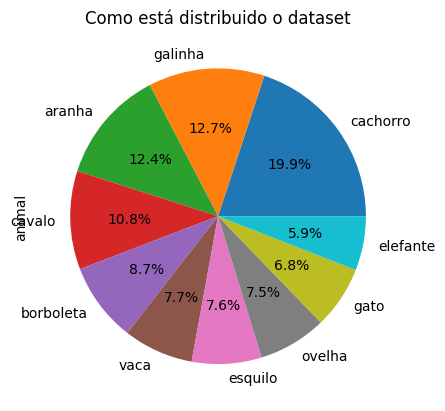

In [ ]:
#Visualizando como está dividido o conjunto de dados por classe
df['animal'].value_counts().plot.pie(title='Como está distribuido o dataset', autopct='%1.1f%%')

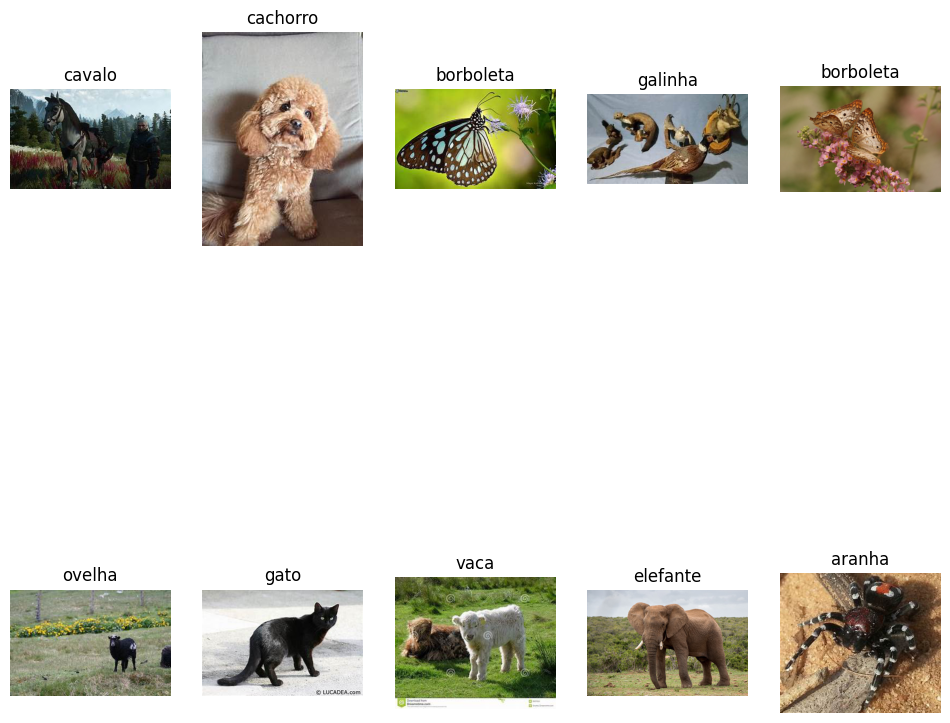

In [ ]:
#visualizando algumas imagens do conjunto de dados
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)
for i, row in df.sample(n=10).reset_index().iterrows():
    plt.subplot(2,5,i+1)
    image_path = row['images']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["animal"])
    plt.axis('off')
plt.show()

## 3. Separação do dados de Treino e teste

Divisão dos dados em treino e teste: 30% das imagens para teste e 70 para treino do modelo de deep learning.

In [ ]:
df_train, df_tem = train_test_split(df[['images', 'animal']].reset_index(drop=True), test_size=0.3, random_state=30, shuffle=True)
df_test, df_val = train_test_split(df_tem, test_size=0.6, random_state=30, shuffle=True)



In [ ]:
#Resumo da separação do conjunto de dados
print("#########Train##############")
print(df_train.head())
print(df_train.shape)
print("#########Test###############")
print(df_test.head())
print(df_test.shape)
print("#########Validação###############")
print(df_val.head())
print(df_val.shape)

#########Train##############
                                                  images    animal
10282  /content/drive/MyDrive/Puc - Pós em Ciência ...    ovelha
18342  /content/drive/MyDrive/Puc - Pós em Ciência ...   galinha
2779   /content/drive/MyDrive/Puc - Pós em Ciência ...    cavalo
15165  /content/drive/MyDrive/Puc - Pós em Ciência ...  cachorro
1105   /content/drive/MyDrive/Puc - Pós em Ciência ...      vaca
(17071, 2)
#########Test###############
                                                  images    animal
16334  /content/drive/MyDrive/Puc - Pós em Ciência ...   galinha
5320   /content/drive/MyDrive/Puc - Pós em Ciência ...    aranha
4540   /content/drive/MyDrive/Puc - Pós em Ciência ...    aranha
4790   /content/drive/MyDrive/Puc - Pós em Ciência ...    aranha
14158  /content/drive/MyDrive/Puc - Pós em Ciência ...  cachorro
(2926, 2)
#########Validação###############
                                                  images     animal
1989   /content

#### Preparação dos dados



Através da classe **ImageDataGenerator** do TensorFlow iremos configurar geradores de dados para o treinamento, validação, e teste

In [ ]:
%%time

BATCH_SIZE = 20 #Defino o tamanho do lote
IMAGE_SIZE = (150, 150) #Defino o tamanho das imagens

train_datagen=ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train,
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    seed = 20,
    shuffle=False
    )

val_generator=val_datagen.flow_from_dataframe(
    dataframe=df_val,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False
    )

test_generator=test_datagen.flow_from_dataframe(
    dataframe = df_test,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False)

Found 17071 validated image filenames belonging to 10 classes.
Found 4391 validated image filenames belonging to 10 classes.
Found 2926 validated image filenames belonging to 10 classes.
CPU times: user 307 ms, sys: 775 ms, total: 1.08 s
Wall time: 3.96 s


Found 1 validated image filenames belonging to 1 classes.


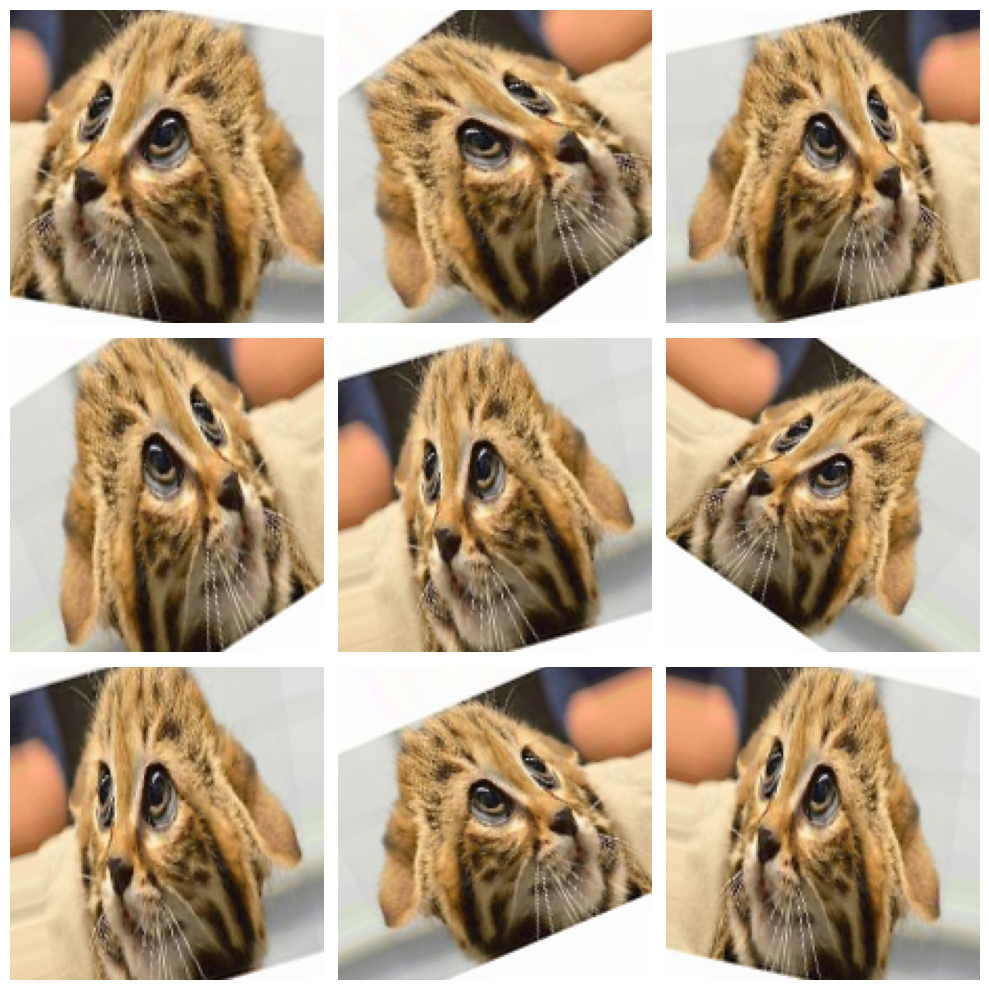

In [ ]:
#Visualizo uma imagem com o class_mode="categorical"
sample = df.sample(n=1)

sample_generator = train_datagen.flow_from_dataframe(
    dataframe = sample,
    x_col='images',
    y_col='animal',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode ='rgb',
)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

## 4. Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN)



In [ ]:
num_classes = len(set(train_generator.classes))

# Data Augmentation Step
augment = tf.keras.Sequential()


inputs = layers.Input(shape=(150, 150, 3), name='inputLayer')
x = augment(inputs)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes, activation='softmax')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = Model(inputs=inputs, outputs=outputs)


print(model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 72, 72, 128)      512       
 hNormalization)                                           

## 5. Treinamento do modelo de deep learning

O código abaixo irá compilar o modelo usando o otimizador Adam com de aprendizado de 0.00001. Como tenho um dataset com mais de 10 categorias, utilizo a função de perda como "categorical_crossentropy".


Em seguida, crio um modelo de treinamento com 20 epochs e defino o comprimento com o tamanho de train generator e val generator.

Dois callbacks serão utlizados durante o treinamento:

O EarlyStopping monitora a perda de validação (val_loss) e interrompe o treinamento caso a perda não melhore após 5 épocas.

O ReduceLROnPlateau monitora a perda de validação (val_loss) e reduz a taxa de aprendizado em 0.2 caso a perda não melhore após 2 épocas.

In [ ]:
%%time

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


CPU times: user 8.54 ms, sys: 71 µs, total: 8.62 ms
Wall time: 8.2 ms


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True), #Monitoro val_loss e interrompo o treinamento caso a métrica não melhore em 5 epochs
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min'), #Monitoto val_loss e reduzo a taxa de aprendizado em 0.2 quando a métrica fica estagnada
                              ]
)

Epoch 1/20
854/854 [==============================] - 140s 164ms/step - loss: 1.8855 - accuracy: 0.5951 - val_loss: 1.9083 - val_accuracy: 0.5607 - lr: 3.2000e-09
Epoch 2/20
854/854 [==============================] - 141s 165ms/step - loss: 1.8868 - accuracy: 0.5936 - val_loss: 1.9067 - val_accuracy: 0.5596 - lr: 3.2000e-09
Epoch 3/20
854/854 [==============================] - 140s 164ms/step - loss: 1.8855 - accuracy: 0.5948 - val_loss: 1.9103 - val_accuracy: 0.5593 - lr: 3.2000e-09
Epoch 4/20
854/854 [==============================] - 140s 164ms/step - loss: 1.8831 - accuracy: 0.5991 - val_loss: 1.9107 - val_accuracy: 0.5561 - lr: 3.2000e-09
Epoch 5/20
854/854 [==============================] - 140s 164ms/step - loss: 1.8882 - accuracy: 0.5916 - val_loss: 1.9072 - val_accuracy: 0.5609 - lr: 6.4000e-10
Epoch 6/20
854/854 [==============================] - 140s 164ms/step - loss: 1.8847 - accuracy: 0.5961 - val_loss: 1.9122 - val_accuracy: 0.5575 - lr: 6.4000e-10
Epoch 7/20
854/854 [==

#### Exibo o desempenho do modelo

Crio um código para visualiza a evolução da perda e acurácia ao longo das épocas durante o treinamento e validação do modelo. Isso permitirá uma análise visual do desempenho do modelo e ajuda a identificar possíveis problemas, como overfitting ou underfitting.

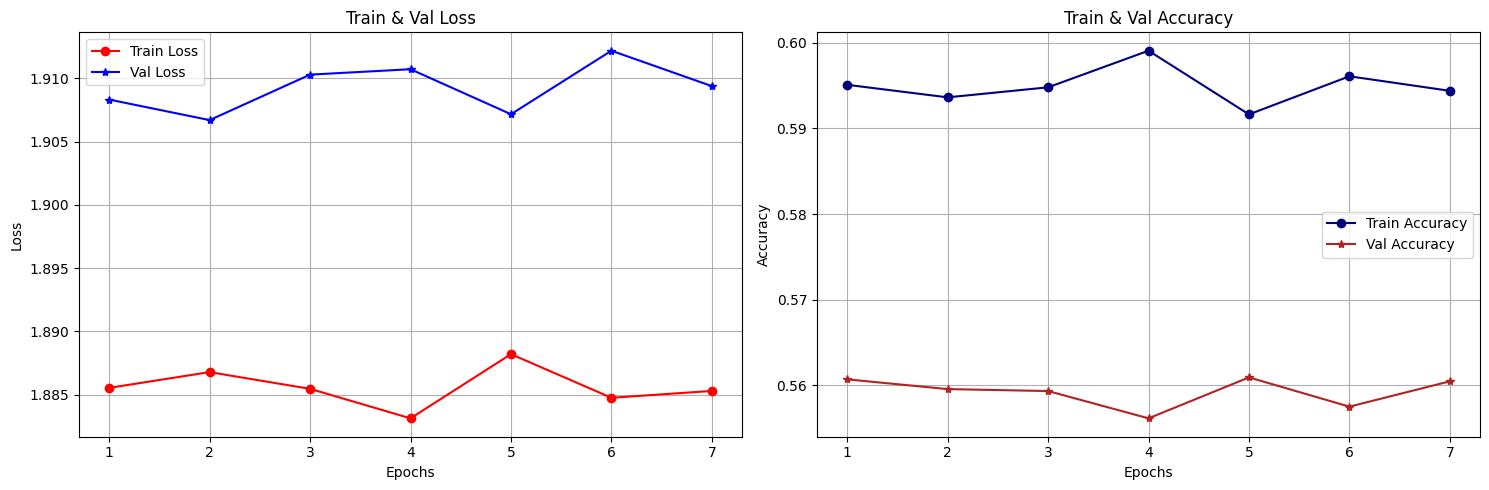

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

epochs = range(1, len(history.history['accuracy']) + 1)
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']

ax[0].plot(epochs, loss_vals, color='red', marker='o', linestyle='-', label='Train Loss')
ax[0].plot(epochs, val_loss_vals, color='blue', marker='*', linestyle='-', label='Val Loss')
ax[0].set(title='Train & Val Loss', xlabel='Epochs', ylabel='Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].plot(epochs, acc_vals, color='navy', marker='o', linestyle='-', label='Train Accuracy')
ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', linestyle='-', label='Val Accuracy')
ax[1].set(title='Train & Val Accuracy', xlabel='Epochs', ylabel='Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.tight_layout()
plt.show()

#### Previsões

Crio um DataFrame chamado Predictions com as informações de previsão do modelo. O DataFrame terá as seguintes colunas:

*   "Image Index": Índice da imagem no conjunto de teste
*   "Test Labels": Rótulos reais das imagens no conjunto de teste
*   "Test Classes": Classes correspondentes aos rótulos reais
*   "Prediction Labels": Rótulos previstos pelo modelo
*   "Prediction Classes": Classes correspondentes aos rótulos previstos
*   "Path": Caminho dos arquivos de imagem
*   "Prediction Probability": Probabilidade da classe prevista pelo modelo

In [ ]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index": list(range(len(test_generator.labels))),
                            "Test Labels": test_generator.labels,
                            "Test Classes": [classes[i] for i in test_generator.labels],
                            "Prediction Labels": y_pred,
                            "Prediction Classes": [classes[i] for i in y_pred],
                            "Path": test_generator.filepaths,
                            "Prediction Probability": [x for x in np.asarray(np.max(model.predict(test_generator), axis=1))]
                           })
Predictions.head(10)

147/147 [==============================] - 9s 63ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0            6      galinha                  6   
1            1            0       aranha                  1   
2            2            0       aranha                  0   
3            3            0       aranha                  0   
4            4            2     cachorro                  8   
5            5            8       ovelha                  1   
6            6            6      galinha                  6   
7            7            5      esquilo                  5   
8            8            9         vaca                  9   
9            9            9         vaca                  8   

  Prediction Classes                                               Path  \
0            galinha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
1          borboleta  /content/drive/MyDrive/Puc - Pós em Ciência ...   
2             aranha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
3             aranha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
4             ovelha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
5          borboleta  /content/drive/MyDrive/Puc - Pós em Ciência ...   
6            galinha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
7            esquilo  /content/drive/MyDrive/Puc - Pós em Ciência ...   
8               vaca  /content/drive/MyDrive/Puc - Pós em Ciência ...   
9             ovelha  /content/drive/MyDrive/Puc - Pós em Ciência ...   

   Prediction Probability  
0                0.230652  
1                0.210560  
2                0.225637  
3                0.225427  
4                0.227555  
5                0.151167  
6                0.220575  
7                0.218933  
8                0.134286  
9                0.183811

## 6. Execução do modelo treinado em um subconjunto das imagems de teste com as previsões vinculadas


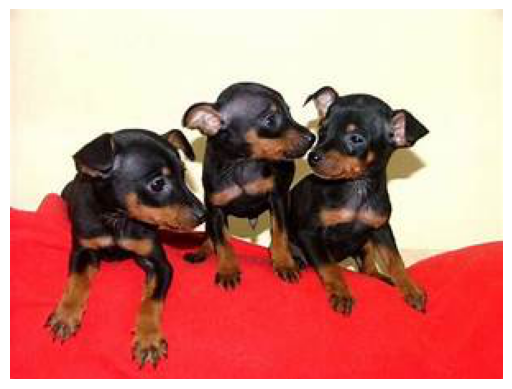

True Label:  cachorro
Predicted Label:  cachorro
Probability:  0.2



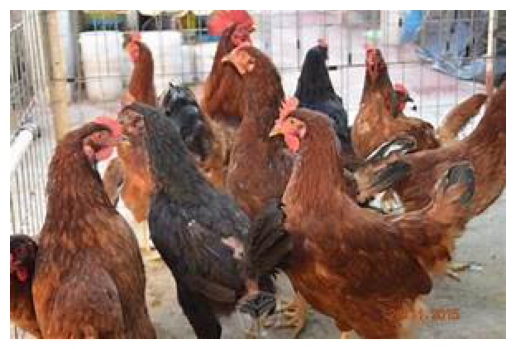

True Label:  galinha
Predicted Label:  galinha
Probability:  0.23



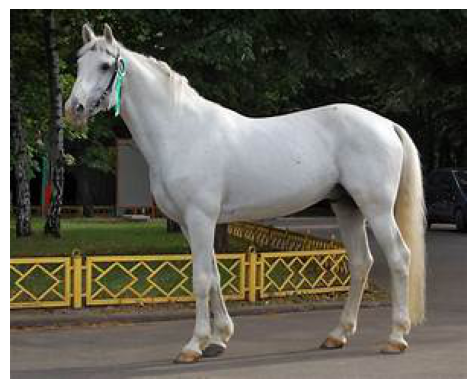

True Label:  cavalo
Predicted Label:  cavalo
Probability:  0.23



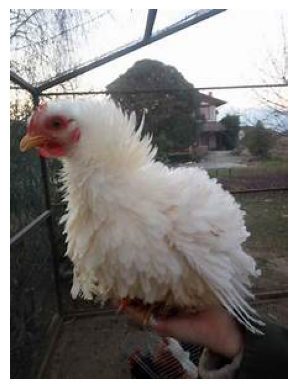

True Label:  galinha
Predicted Label:  galinha
Probability:  0.19



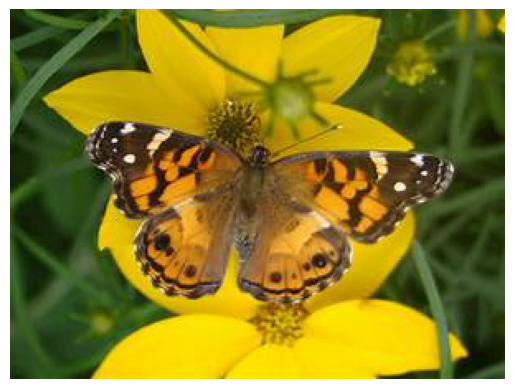

True Label:  borboleta
Predicted Label:  borboleta
Probability:  0.23



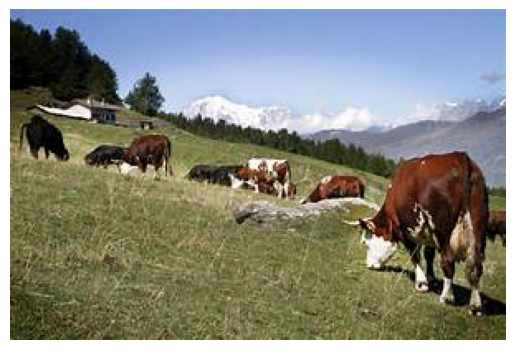

True Label:  vaca
Predicted Label:  vaca
Probability:  0.19



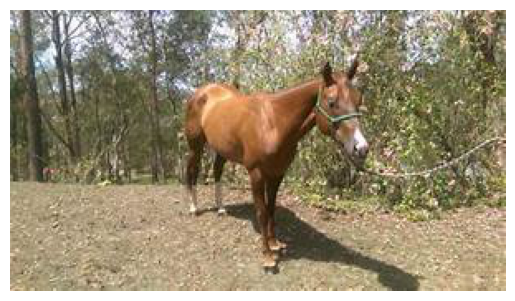

True Label:  cavalo
Predicted Label:  elefante
Probability:  0.2



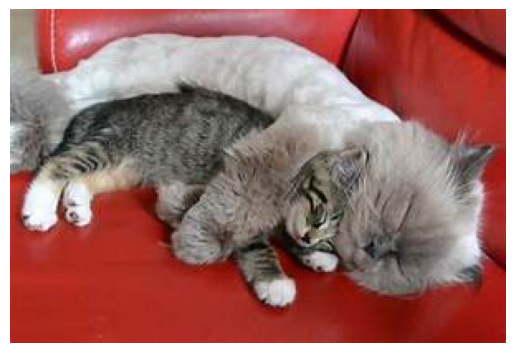

True Label:  gato
Predicted Label:  aranha
Probability:  0.13



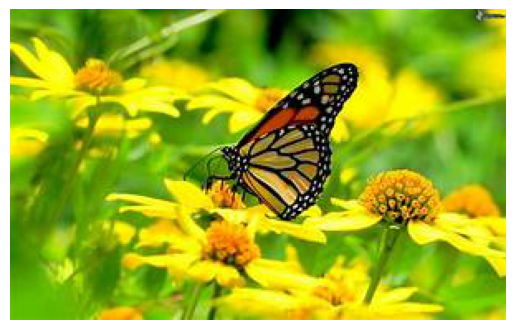

True Label:  borboleta
Predicted Label:  borboleta
Probability:  0.23



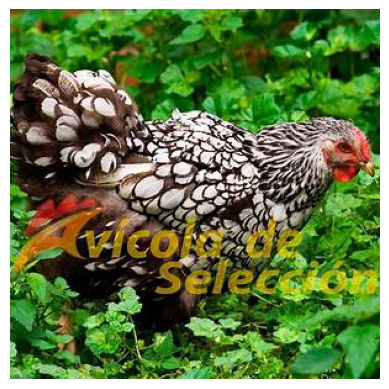

True Label:  galinha
Predicted Label:  borboleta
Probability:  0.23



In [ ]:
# Obtendo uma amostra aleatória de 10 linhas do DataFrame Predict

sample_predictions = Predictions.sample(n=10)

for index, row in sample_predictions.iterrows():
    # Obtendo as informações necessárias para visualização e impressão
    image = plt.imread(row['Path'])
    true_label = row['Test Classes']
    predicted_label = row['Prediction Classes']
    probability = row['Prediction Probability']

    # Arredondando a probabilidade para duas casas decimais
    probability = round(probability, 2)

    # Configuração da figura para exibir a imagem
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Impressão dos resultados da classificação
    print("True Label: ", true_label)
    print("Predicted Label: ", predicted_label)
    print("Probability: ", probability)
    print()

## 7. Avaliação do modelo de deep learning


In [ ]:
results = model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.2f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.90
Test Accuracy: 56.29%


In [ ]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

# Arredondar os valores para duas casas decimais
accuracy = round(accuracy, 2)
precision = round(precision, 2)
recall = round(recall, 2)
f1score = round(f1score, 2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1score)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

Accuracy: 0.56
Precision: 0.6
Recall: 0.56
F1 Score: 0.55
              precision    recall  f1-score   support

      aranha       0.70      0.60      0.65       327
   borboleta       0.55      0.84      0.66       233
    cachorro       0.69      0.56      0.62       592
      cavalo       0.65      0.57      0.61       321
    elefante       0.50      0.54      0.52       194
     esquilo       0.56      0.46      0.51       251
     galinha       0.43      0.88      0.58       393
        gato       0.62      0.08      0.14       185
      ovelha       0.47      0.38      0.42       207
        vaca       0.64      0.36      0.46       223

    accuracy                           0.56      2926
   macro avg       0.58      0.53      0.52      2926
weighted avg       0.60      0.56      0.55      2926



Matriz de confusão sem normalização


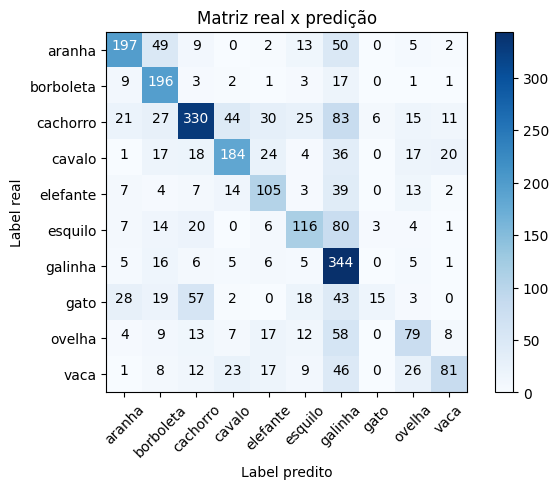

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt_str = '{:d}' if not normalize else '{:.2f}'

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_str.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

class_names = list(test_generator.class_indices.values())
y_pred = Predictions['Prediction Labels']
y_test = Predictions['Test Labels']
Map_class = test_generator.class_indices

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=Map_class,
                      normalize=False,
                      title='Matriz real x predição')

## 8. Exportação do modelo de deep learning para posterior uso

Salvando o modelo de deep learning que foi treinado em uma pasta no meu google drive

In [ ]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = '/content/drive/MyDrive/Datasets'

name_model = 'trained_model_animal10' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

Modelo salvo com o nome:  trained_model_animal102023-07-17T2111.h5


## 9. Teste do modelo exportado

Carregando o modelo salvo em meu google drive

In [ ]:
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

Modelo trained_model_animal102023-07-17T2111.h5 carregado com sucesso


147/147 [==============================] - 9s 63ms/step


In [ ]:
y_true = test_generator.classes
y_pred = np.argmax(loaded_model.predict(test_generator), axis = 1)

classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index": list(range(len(test_generator.labels))),
                            "Test Labels": test_generator.labels,
                            "Test Classes": [classes[i] for i in test_generator.labels],
                            "Prediction Labels": y_pred,
                            "Prediction Classes": [classes[i] for i in y_pred],
                            "Path": test_generator.filepaths,
                            "Prediction Probability": [x for x in np.asarray(np.max(loaded_model.predict(test_generator), axis=1))]
                           })
Predictions.head(10)


147/147 [==============================] - 9s 62ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0            6      galinha                  6   
1            1            0       aranha                  1   
2            2            0       aranha                  0   
3            3            0       aranha                  0   
4            4            2     cachorro                  8   
5            5            8       ovelha                  1   
6            6            6      galinha                  6   
7            7            5      esquilo                  5   
8            8            9         vaca                  9   
9            9            9         vaca                  8   

  Prediction Classes                                               Path  \
0            galinha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
1          borboleta  /content/drive/MyDrive/Puc - Pós em Ciência ...   
2             aranha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
3             aranha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
4             ovelha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
5          borboleta  /content/drive/MyDrive/Puc - Pós em Ciência ...   
6            galinha  /content/drive/MyDrive/Puc - Pós em Ciência ...   
7            esquilo  /content/drive/MyDrive/Puc - Pós em Ciência ...   
8               vaca  /content/drive/MyDrive/Puc - Pós em Ciência ...   
9             ovelha  /content/drive/MyDrive/Puc - Pós em Ciência ...   

   Prediction Probability  
0                0.230652  
1                0.210560  
2                0.225637  
3                0.225427  
4                0.227555  
5                0.151167  
6                0.220575  
7                0.218933  
8                0.134286  
9                0.183811

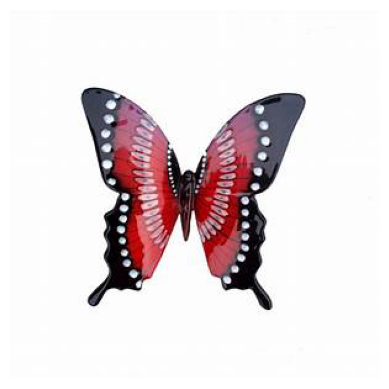

True Label:  borboleta
Predicted Label:  borboleta
Probability:  0.23



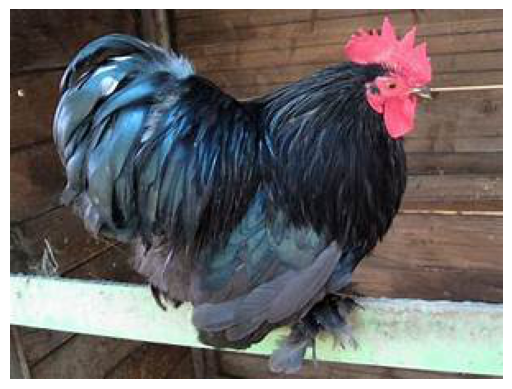

True Label:  galinha
Predicted Label:  galinha
Probability:  0.23



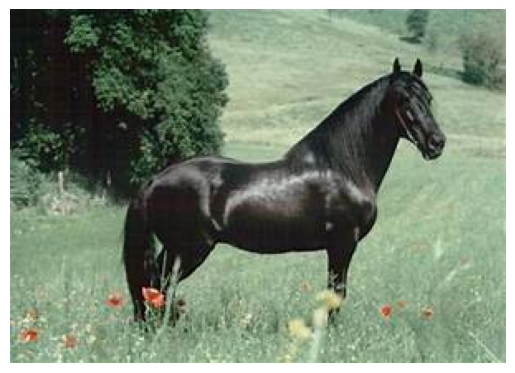

True Label:  cavalo
Predicted Label:  galinha
Probability:  0.22



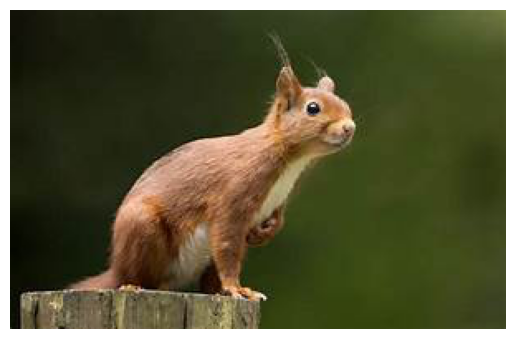

True Label:  esquilo
Predicted Label:  esquilo
Probability:  0.22



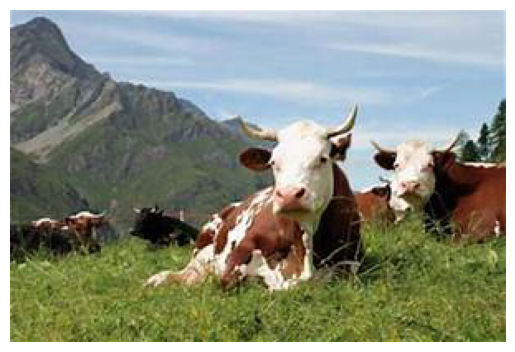

True Label:  vaca
Predicted Label:  ovelha
Probability:  0.18



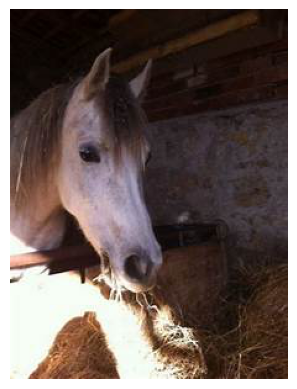

True Label:  cavalo
Predicted Label:  cachorro
Probability:  0.23



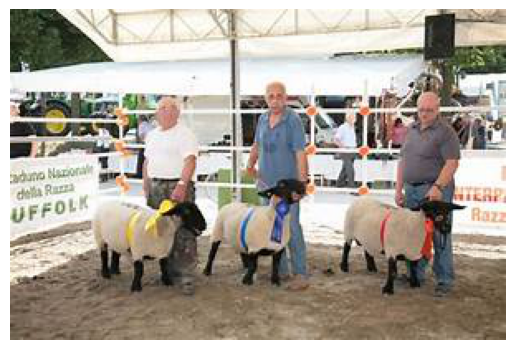

True Label:  ovelha
Predicted Label:  cavalo
Probability:  0.18



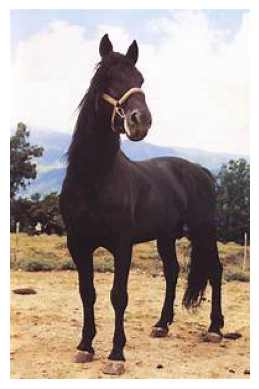

True Label:  cavalo
Predicted Label:  cavalo
Probability:  0.23



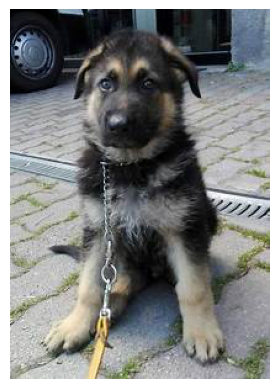

True Label:  cachorro
Predicted Label:  cachorro
Probability:  0.23



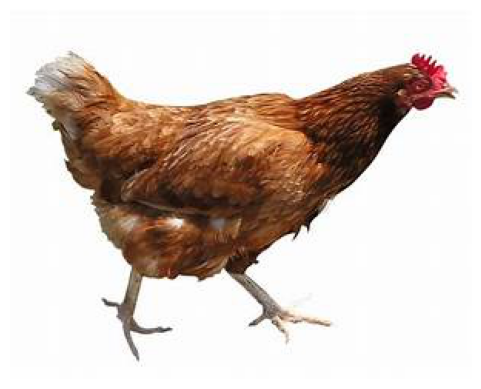

True Label:  galinha
Predicted Label:  galinha
Probability:  0.23



In [ ]:
sample_predictions = Predictions.sample(n=10)

for index, row in sample_predictions.iterrows():
    # Obtendo as informações necessárias para visualização e impressão
    image = plt.imread(row['Path'])
    true_label = row['Test Classes']
    predicted_label = row['Prediction Classes']
    probability = row['Prediction Probability']

    # Arredondando a probabilidade para duas casas decimais
    probability = round(probability, 2)

    # Configuração da figura para exibir a imagem
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Impressão dos resultados da classificação
    print("True Label: ", true_label)
    print("Predicted Label: ", predicted_label)
    print("Probability: ", probability)
    print()